In [116]:
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import numpy as np
from pathlib import Path  # python3 only
import math,datetime
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
state = 'Texas'
keyword = 'transgender'
year = str(2021)
currentYear = datetime.datetime.now().year


In [117]:
keyWords = ['China','black people','immigrant','muslim','transgender','asian']

     2010.count  2010.comp
0          66.0     0.1509
1           NaN        NaN
2          89.0     0.1262
3          27.0    -0.0213
4           9.0     0.0939
..          ...        ...
249         NaN        NaN
250         NaN        NaN
251         NaN        NaN
252         1.0     0.0000
253         1.0    -0.6198

[254 rows x 2 columns]
        County  # of Tweets   score
0       TRAVIS         66.0  0.1509
1      SHERMAN          NaN     NaN
2       DALLAS         89.0  0.1262
3       COLLIN         27.0 -0.0213
4       DENTON          9.0  0.0939
..         ...          ...     ...
249     YOAKUM          NaN     NaN
250   LA SALLE          NaN     NaN
251       HALL          NaN     NaN
252  GALVESTON          1.0  0.0000
253  GUADALUPE          1.0 -0.6198

[254 rows x 3 columns]
     2011.count  2011.comp
0         454.0     0.1435
1           NaN        NaN
2         240.0     0.0753
3          89.0     0.1124
4          83.0     0.2760
..          ...        ...
249    

No handles with labels found to put in legend.



        County  # of Tweets   score
0       TRAVIS        584.0  0.2150
1      SHERMAN          NaN     NaN
2       DALLAS        937.0  0.1438
3       COLLIN        182.0  0.2145
4       DENTON         74.0  0.2759
..         ...          ...     ...
249    EL PASO         72.0  0.1394
250   BREWSTER          2.0  0.4510
251   HUDSPETH          8.0 -0.0813
252   PRESIDIO          2.0  0.4510
253  CULBERSON          NaN     NaN

[254 rows x 3 columns]
     2020.count  2020.comp
0         512.0     0.1326
1           NaN        NaN
2        1099.0     0.0570
3         104.0     0.1796
4          90.0     0.0549
..          ...        ...
249        25.0     0.0457
250         1.0    -0.5916
251         4.0     0.3259
252         1.0    -0.5916
253         NaN        NaN

[254 rows x 2 columns]
        County  # of Tweets   score
0       TRAVIS        512.0  0.1326
1      SHERMAN          NaN     NaN
2       DALLAS       1099.0  0.0570
3       COLLIN        104.0  0.1796
4       DENTON 

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

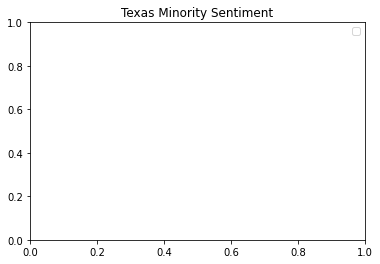

In [118]:
averageSentKeyword = {}
mentionsKeyword = {}
for keyword in keyWords:
    yearList = []
    averageSentimentOverTime = []
    json_folder = 'Keyword State'
    file_dir = Path.cwd()
    file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))
    shape_dir = os.path.join(file_dir, 'Shapes', 'United States','USA_Counties.shx')
    # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
    f = open(file_path, 'r')
    state_dict = json.load(f)
    stateDF = pd.DataFrame.from_dict(state_dict, orient='index')
    stateDF.reset_index(inplace=True)
    # stateDF = stateDF[[0,1,2]]
    stateDF.rename(columns={'index': 'County', 0 :'# of Tweets',1:'score',2:'Time'}, inplace=True)
    timeDF = pd.json_normalize(stateDF['Time'])
    stateDF.drop('Time',axis = 1,inplace= True)
    maxCount = timeDF[list(timeDF.filter(regex=('count')))].max().max()
    for year in range(2006,currentYear+1):
        year = str(year)
        if(len(list(timeDF.filter(regex=year)))>0):
            
            slicetimeDF = timeDF[list(timeDF.filter(regex=('County|' + year+'.comp|' + year+'.count')))]
            county=timeDF[list(timeDF.filter(regex=('County|' + year+'.count')))]
            print(slicetimeDF)
            stateDF = pd.concat([stateDF['County'], slicetimeDF], axis=1)
            stateDF.rename(columns= {stateDF.columns[1]:'# of Tweets',stateDF.columns[2]:'score'}, inplace=True)
            json_folder = 'Keyword State'
            file_dir = Path.cwd()
            file_path = os.path.join(file_dir, json_folder, (((state) + " on the term " + keyword +'.json')))

            # Okay turn the dictionary into a dataframe where one column is filled with keys, and the other column is the first value in the dictionary
            f = open(file_path, 'r')
            score = []
            j=0

            #-------------------------------------
            #-------------------------------------
            # AVERAGE SENT. AND TOTAL POP.
            # get the sum of all values in a column
            totalTweets = stateDF.iloc[:, 1].sum()
            averageSentiment = 0
            k=0
            print(stateDF)
            for score in stateDF['score']:
                if(math.isnan(score)==False):
                    # multiply all values in the score column by the corresponding value in the population column
                    averageSentiment += score * stateDF.iat[k,1]
                k+=1
            averageSentiment=averageSentiment/totalTweets
            yearList.append(int(year))
            averageSentimentOverTime.append([averageSentiment,int(year)])

        
    # averageSentimentOverTime = scaler.fit_transform(averageSentimentOverTime)
    totalTweets = stateDF.iloc[:, 1].sum()
    print(totalTweets)
    if keyword in mentionsKeyword:
        mentionsKeyword[keyword].append([totalTweets,year])
    else:
        mentionsKeyword[keyword] = [totalTweets]
    
    a, b = zip(*averageSentimentOverTime)

    # plt.plot(b,a,label = keyword)

# np.vstack(averageSentimentOverTime,yearList)
print(mentionsKeyword)
plt.title('Texas Minority Sentiment')

plt.legend()

# print(list(averageSentKeyword.values())[0])
# print(scaler.fit_transform(list(averageSentKeyword.values())[0]))
SentimentYear = {}
topKeys = averageSentKeyword.keys()

for i in range(len(averageSentKeyword.values())):
    # averageSentKeyword.values()[i]
    sentiment, year = zip(*list(averageSentKeyword.values())[i])
    for j in range(len(year)):
        if year[j] in SentimentYear:
            SentimentYear[year[j]].append(sentiment[j])
        else:
            SentimentYear[year[j]] = [sentiment[j]]
            # Sentiment year is the sorted matrix which is passed through the normalizign function
            # The columns are a measure of the given year
            # The rows are the different keywords
topKeys = list(topKeys)

normalizedSentiment =  scaler.fit_transform(list(SentimentYear.values()))
NormalizedData =pd.DataFrame(SentimentYear.values(), columns=topKeys, index=SentimentYear.keys())
# NormalizedData.rename(topKeys,inplace=True)
remappedData = []
for i in range(len(NormalizedData.columns)):
    testData = NormalizedData[[topKeys[i]]].values.tolist()
    a = testData
    a=list(a)
    # a= np.column_stack((a,yearList)).tolist()
    # Merge the list "a" and the liat 'yearList' as if they were two columns in a matrix
    # "a" is a list of n-arrays (each array is a data row), "yearList" is a list of integers

    remappedData.append(list(a))
for i in range(len(remappedData)):

    plt.plot(yearList,remappedData[i],label = topKeys[i])

plt.legend()
